In [310]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

df = pd.read_json('../data/database-10-12.json')

In [311]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [312]:
df = df.loc[(df['date'] >= "2022-07-16") & (df['date'] <= "2022-12-10")]

#### Fülle alle NaN Werte aus `rankings` mit einem leeren Array

In [314]:
df['rankings'] = df['rankings'].fillna("[]")

#### Füge ein neues Feature hinzu: Themengebiet

In [315]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topic

#### Füge vier neue Features hinzu: Tag, Woche, Monat, Jahr

In [316]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#### Füge ein neues Feature hinzu: Ranking besser als 5. Platz

In [317]:
def high_ranking(x):
    if (type(x) == list):
        return any(ranking['score'] <= 5 for ranking in x)
    return False

df['high_ranking'] = df['rankings'].apply(high_ranking)

#### Filter die Artikel nach: Hohes Ranking vorhanden

In [318]:
df = df.loc[df.high_ranking]

## Gruppiere die Artikel eines Themengebiets nach: Woche (eindeutig)
#### Füge alle entstandenen Daten mit `merge` zusammen

In [319]:
df_all_week = None

for topic in topics:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_topic = df.loc[df.topic == topic]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_week_topic = df_topic.groupby(["week", "year"]).size().reset_index(name=topic)
    
    # Füge ein neues Feature hinzu: Datum
    df_week_topic['date'] = df_week_topic['week'].astype(str) + " " + df_week_topic['year'].astype(str)

    # Lösche zwei Features: Woche, Jahr
    df_week_topic.drop(['week', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all_week, pd.DataFrame)):
        df_all_week = pd.merge(df_all_week, df_week_topic, how='outer', on="date")
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all_week = df_week_topic

df_all_week = df_all_week.fillna(0)

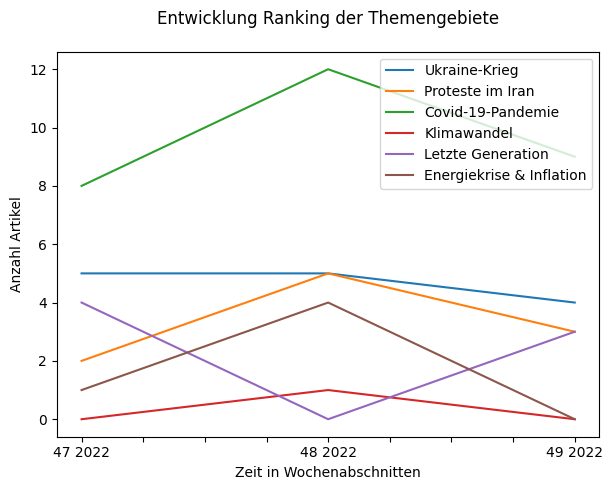

In [320]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_all_week.plot(kind="line", x="date", y=list(topics), ax=ax, xlabel="Zeit in Wochenabschnitten", figsize=(7,5), ylabel="Anzahl Artikel", legend=True)

ax.set_title(f'Entwicklung Ranking der Themengebiete', pad=20)

fig.savefig(f'figures/line-ranking-trend-topic-weekly.png')

## Gruppiere die Artikel eines Themengebiets nach: Tag (eindeutig)
#### Füge alle entstandenen Daten mit `merge` zusammen

In [321]:
df_all_day = None

for topic in topics:
    # Betrachte nur die Artikel des aktuellen Themengebiets
    df_topic = df.loc[df.topic == topic]
    # Gruppiere die Artikel nach Woche (eindeutig) und aggregiere die Anzahl der Artikel pro Woche
    df_daily_topic = df_topic.groupby(["day", "month", "year"]).size().reset_index(name=topic)
    
    # Füge ein neues Feature hinzu: Datum
    df_daily_topic['date'] = df_daily_topic['day'].astype(str) + " " + df_daily_topic['month'].astype(str) + " " + df_daily_topic['year'].astype(str)

    # Lösche zwei Features: Woche, Jahr
    df_daily_topic.drop(['day', 'month', 'year'], axis=1, inplace=True)

    # Falls der df der Gesamtdaten bereits Daten von vorherigen Themengebieten enthält, merge die Daten des aktuellen Themengebiets
    if (isinstance(df_all_day, pd.DataFrame)):
        df_all_day = pd.merge(df_all_day, df_daily_topic, how='outer', on="date")
    # Initialisiere den df der Gesamtdaten mit den Daten des aktuellen Themengebiets
    else:
        df_all_day = df_daily_topic

# Fülle die leeren Felder mit der Anzahl 0
df_all_day = df_all_day.fillna(0)

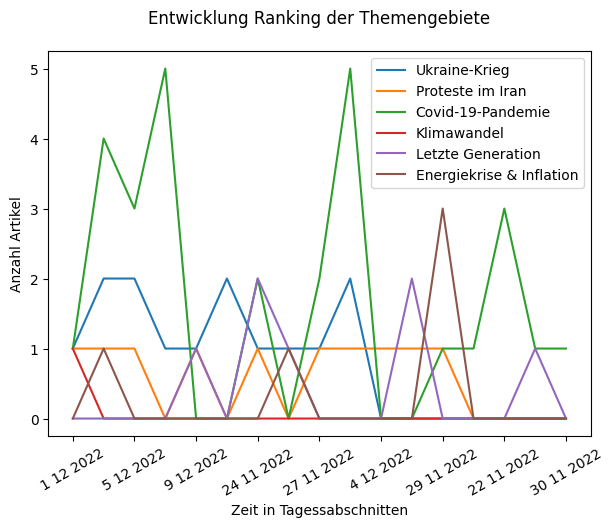

In [322]:
plt.style.use('default') # 'default' or 'dark_background'

fig, ax = plt.subplots()

ax = df_all_day.plot(kind="line", x="date", y=list(topics), ax=ax, rot=30, xlabel="Zeit in Tagessabschnitten", figsize=(7,5), ylabel="Anzahl Artikel", legend=True)

ax.set_title(f'Entwicklung Ranking der Themengebiete', pad=20)

fig.savefig(f'figures/line-ranking-trend-topic-daily.png')